Based on: https://github.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/blob/main/code/Ch9/Chapter%209.ipynb

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from plotnine import *
from statsmodels.datasets import co2

# Data Loading

In [2]:
co2_df=co2.load_pandas().data
co2_df=co2_df.ffill()
print(co2_df.shape)
co2_df.head(5)

(2284, 1)


,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


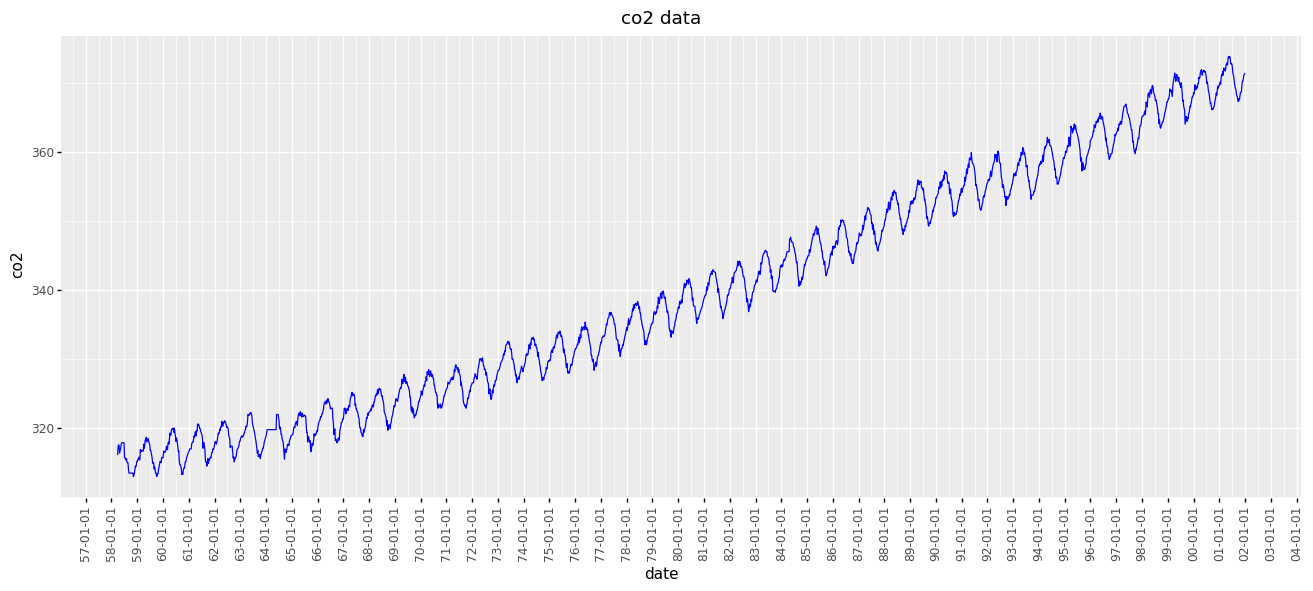

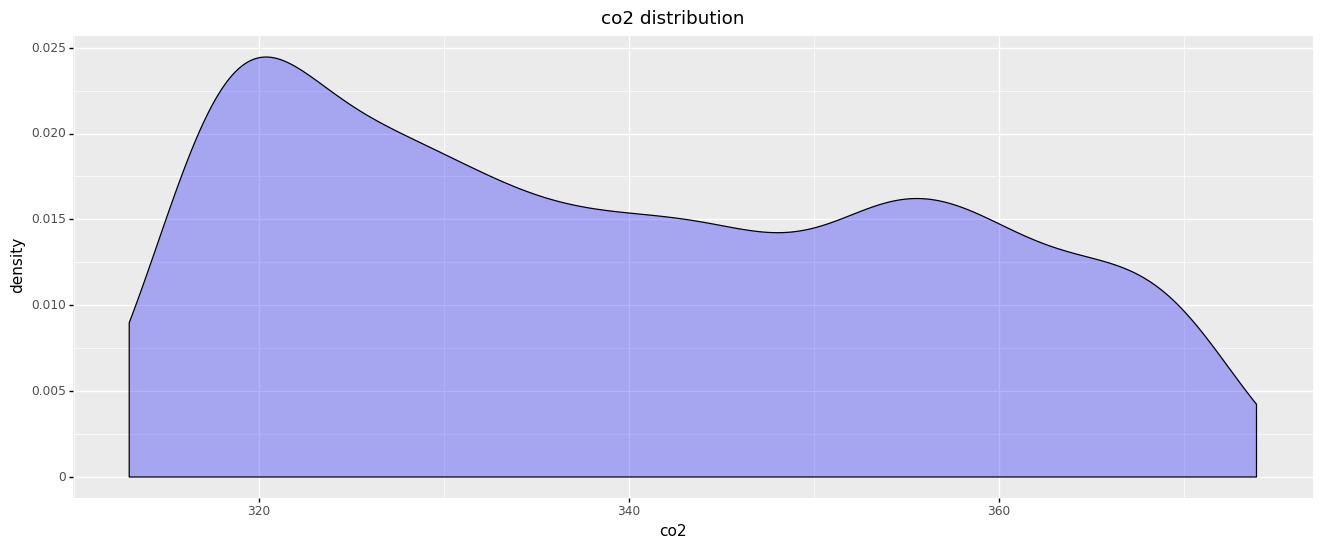

In [3]:
temp_df=co2_df.reset_index().rename(columns={'index':'date'})
print(
    ggplot(temp_df, aes('date','co2'))
    #+geom_point(color='blue')
    +geom_line(color='blue')
    +scale_x_datetime(date_labels=('%y-%m-%d'),date_breaks='1 years')
    +theme(axis_text_x=element_text(angle=90),figure_size=(16,6))
    +labs(title='co2 data')
          )
print(
    ggplot(temp_df,aes('co2'))
    +geom_density(fill='blue',alpha=0.3)
    +theme(figure_size=(16,6))
    +labs(title='co2 distribution')
    

)

# 9.4 Detecting Time Series Stationarity 
* Stationarity: constant mean, constant variance, consistent covariance between identical distanced periods (lags)
* adfuller
* kpss

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss

### Pring test results 

In [18]:
def print_results(output,test='adf'):
    
    pval=output[1]
    test_score=output[0]
    lags=output[2]
    
    decision='Non-Stationary'
    
    if test=='adf':
        critical=output[4]
        if pval<0.05:
            decision='Stationary'
    elif test=='kpss':
        critical=output[3]
        if pval>=0.05:
            decision='Stationary'
    
    output_dict={
        'Test Statistic':test_score,
        'p-value':pval,
        'Number of lags':lags,
        'decision':decision
    }
    
    for key,value in critical.items():
        output_dict['Critical Value (%s)' % key]=value
    
    return pd.Series(output_dict,name=test)
    
    

## 9.4.1 Implementation

In [19]:
adf_output=adfuller(co2_df)
kpss_output=kpss(co2_df)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



In [20]:
pd.concat([
    print_results(adf_output,'adf'),
    print_results(kpss_output,'kpss')
],axis=1)

,adf,kpss
Test Statistic,0.046051,8.183188
p-value,0.962179,0.01
Number of lags,27,27
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.433252,0.739
Critical Value (5%),-2.862822,0.463
Critical Value (10%),-2.567452,0.347
Critical Value (2.5%),NaN,0.574


In [23]:
adf_output[4].items()

dict_items([('1%', -3.4332519309441296), ('5%', -2.8628219967376647), ('10%', -2.567452466810334)])

In [30]:
for key,value in adf_output[4].items():
    output_dict_test['critical value (%s)' % key]=value

In [31]:
output_dict_test

{'critical value (1%)': -3.4332519309441296,
 'critical value (5%)': -2.8628219967376647,
 'critical value (10%)': -2.567452466810334}

## 9.4.2 Detrending 

### Create functions  

In [5]:
def check_stationarity(df):
    kps=kpss(df)
    adf=adfuller(df)
    
    kpss_pv,adf_pv=kps[1],adf[1]
    kpssh,adfh='Stationary','Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh='Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hupothesis
        kpssh='Non Stationary'
    return(kpssh,adfh)

In [35]:
def plot_comparison(methods,plot_type='line'):
    n=len(methods)//2
    fig,ax=plt.subplots(n,2,sharex=True,figsize=(20,10))
    for i,method in enumerate(methods):
        method.dropna(inplace=True)
        name=[n for n in globals() if globals()[n] is method]
        v,r=i//2,i%2
        
        kpss_s,adf_s=check_stationarity(method)
        
        method.plot(kind=plot_type,
                    ax=ax[v,r],
                    legend=False,
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}'
                   )
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r],legend=False)

###  Methods

In [26]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [31]:
# 01 first order differencing
first_order_diff=co2_df.diff().dropna() 
first_order_diff_52=co2_df.diff(52).dropna() # to remove seasonality

# 02 second order differencing
second_ord_diff_52=co2_df.diff(52).diff().dropna() # to remove seasonality
second_ord_diff=co2_df.diff().diff().dropna()

# 03 subtracting moving average
rolling_mean=co2_df.rolling(window=52).mean()
subt_roll_mean=co2_df-rolling_mean

# 04 log transformation
log_transform=np.log(co2_df)

# 05 Using series decomposition to remove the trend
decomp=seasonal_decompose(co2_df) # default method - additive
sd_detrend=decomp.observed - decomp.trend # decomp.observed = co2_df, should decomp.seasonal be removed also?

# 06 using Hodrick-Prescott filter to remove trend
cylic_extract, trend=hpfilter(co2_df)

### Review results 

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/home/ubuntu/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value

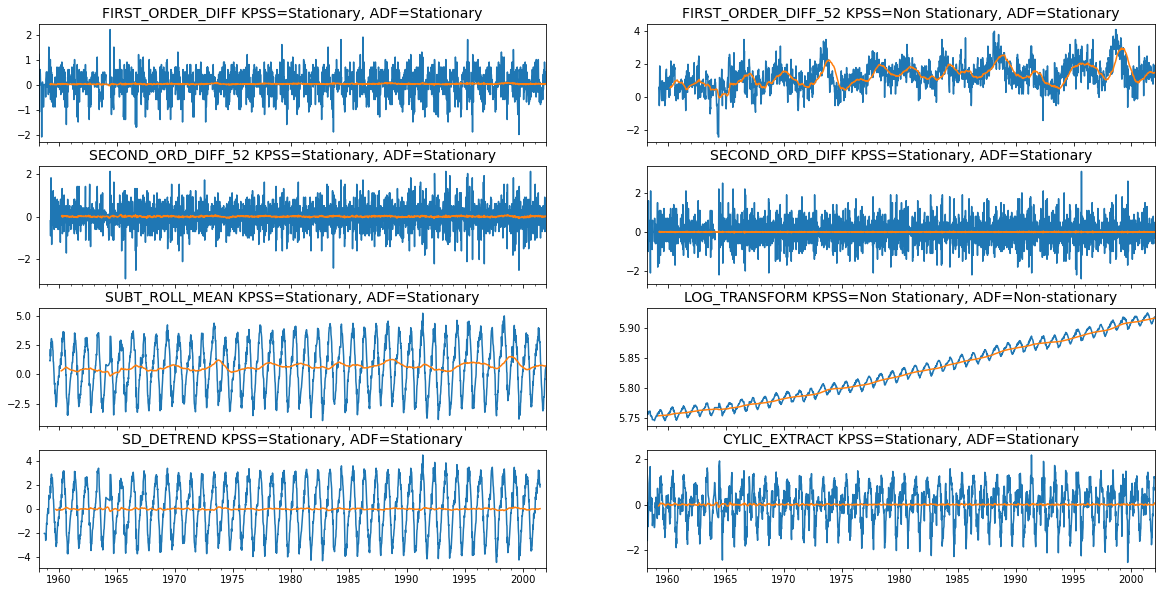

In [36]:
methods=[first_order_diff,first_order_diff_52,
         second_ord_diff_52,second_ord_diff,
         subt_roll_mean,
         log_transform,
         sd_detrend,
         cylic_extract
        ]
plot_comparison(methods)

# first_order_diff already made the time series stationary, and thus there was no need to difference it any further


### There is more: summary  

In [42]:
adf_result=adfuller(first_order_diff,
                    store=True # view OLS results
                   )
adf_result 
# t-statistics
# p-value
# critical values for 1%, 5% and 10% intervals
# ResultStore

(-15.517472045988958,
 2.3063609140309003e-28,
 {'1%': -3.4332532193008443,
  '5%': -2.862822565622804,
  '10%': -2.5674527697012306},
 <statsmodels.stats.diagnostic.ResultsStore at 0x7ffaaf9fd220>)

In [43]:
adf_result[-1].resols.summary() # 27 lags

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     112.4
Date:                Fri, 06 Jan 2023   Prob (F-statistic):               0.00
Time:                        06:07:42   Log-Likelihood:                -1300.1
No. Observations:                2255   AIC:                             2658.
Df Residuals:                    2226   BIC:                             2824.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2089      0.078    -15.517      0.000      -1.362      -1.056
x2             0.0694      0.074      0.934      0.351      -0.076       0.215
x3             0.0549      0.071      0.771      0.441      -0.085       0.194
x4             0.2661      0.068      3.894      0.000       0.132       0.400
x5             0.4363      0.066      6.603      0.000       0.307       0.566
x6             0.6273      0.064      9.780      0.000       0.502       0.753
x7             0.7159      0.063     11.377      0.000       0.592       0.839
x8             0.8211      0.062     13.246      0.000       0.699       0.943
x9             0.8455      0.061     13.779      0.000       0.725       0.966
x10            0.8269      0.061     13.641      0.000       0.708       0.946
x11            0.7763      0.060     13.011      0.000       0.659       0.893
x12            0.6904      0.058     11.815      0.000       0.576       0.805
x13            0.5949      0.057     10.486      0.000       0.484       0.706
x14            0.4798      0.055      8.736      0.000       0.372       0.588
x15            0.3971      0.053      7.466      0.000       0.293       0.501
x16            0.3136      0.052      6.074      0.000       0.212       0.415
x17            0.2572      0.050      5.096      0.000       0.158       0.356
x18            0.2521      0.050      5.082      0.000       0.155       0.349
x19            0.2443      0.049      4.982      0.000       0.148       0.341
x20            0.2534      0.049      5.211      0.000       0.158       0.349
x21            0.2867      0.048      5.940      0.000       0.192       0.381
x22            0.3286      0.048      6.864      0.000       0.235       0.422
x23            0.3501      0.047      7.426      0.000       0.258       0.443
x24            0.3452      0.046      7.504      0.000       0.255       0.435
x25            0.3440      0.044      7.904      0.000       0.259       0.429
x26            0.2724      0.039      6.924      0.000       0.195       0.350
x27            0.1844      0.032      5.846      0.000       0.123       0.246
x28            0.0940      0.021      4.493      0.000       0.053       0.135
const          0.0299      0.009      3.201      0.001       0.012       0.048
==============================================================================
Omnibus:                       57.058   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.961
Skew:                           0.023   Prob(JB):                     2.21e-29
Kurtosis:                       4.184   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co